In [265]:
import numpy as np
import cv2
from PIL import Image
import os
from matplotlib import pyplot as plt
from timeit import default_timer as timer

In [267]:
# def pilimg_to_cvimg(pil_img):
#     if pil_img.mode == 'RGB':
#         return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
#     elif pil_img.mode == 'L':
#         return np.array(pil_img)
#     else:
#         assert False, "Unexpected image format"
        
# def cvimg_to_pil(cv_img):
#     if len(cv_img.shape) == 3:
#         return Image.fromarray(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))
#     elif len(cv_img.shape) == 2:
#         return Image.fromarray(cv_img)
#     else:
#         assert False, "Unexpected image format"

In [ ]:
# plt.imshow(imgs[0])

In [ ]:
# plt.imshow(imgs[1])

In [104]:
sift = cv2.SIFT_create()

frame0 = pilimg_to_cvimg(imgs[0])
frame1 = pilimg_to_cvimg(imgs[1])

kp0, des0 = sift.detectAndCompute(frame0, None)
kp1, des1 = sift.detectAndCompute(frame1, None)

In [212]:
def get_marked(_img, key_points):
    img = _img.copy()
    for kp in key_points:
        img = cv2.circle(img, (round(kp.pt[0]),round(kp.pt[1])), 1, (255,0,0), 2)
    return img

def marked_solopoint(_img, kp):
    return cv2.circle(_img.copy(), (round(kp.pt[0]),round(kp.pt[1])), 1, (255,0,0), 2)

In [459]:
# plt.imshow(get_marked(frame0, kp0))

In [458]:
# plt.imshow(get_marked(frame1, kp1))

In [484]:
def visualize_ransac(x, y, found_x, found_y, thres, inliers_mask, vis_path):
    """ Визуализация метода RANSAC на графике
    """
    inliers_x, inliers_y = x[inliers_mask], y[inliers_mask]
    outliers_x, outliers_y = x[~inliers_mask], y[~inliers_mask]
    inliers_number = np.sum(inliers_mask)
    outliers_number = inliers_mask.shape[0] - inliers_number
    figure, axes = plt.subplots()
    border_circle = plt.Circle((found_x, found_y), radius=thres, color='g', fill=False, label='Border')
    inliers, = axes.plot(inliers_x, inliers_y, 'ro', color='r', markersize=1, label="Inliers ({})".format(inliers_number))
    outliers, = axes.plot(outliers_x, outliers_y, 'ro', color='b', markersize=1, label="Outliers ({})".format(outliers_number))
    model = axes.scatter(found_x, found_y, s=25, color='k', label="Model")
    axes.add_artist(border_circle)
    
    lower_quantile = 0.2
    upper_quantile = 0.8
    min_radius_ratio = 2
    lowX = min(np.quantile(x, q=lower_quantile), found_x - min_radius_ratio * thres)
    uppX = max(np.quantile(x, q=upper_quantile), found_x + min_radius_ratio * thres)
    lowY = min(np.quantile(y, q=lower_quantile), found_y - min_radius_ratio * thres)
    uppY = max(np.quantile(y, q=upper_quantile), found_y + min_radius_ratio * thres)
    axes.set_xlim([lowX, uppX])
    axes.set_ylim([lowY, uppY])

    axes.legend(handles=[model, inliers, outliers, border_circle])
    axes.set(xlabel='$\Delta X$', ylabel=r'$\Delta Y$')
    axes.set_title('RANSAC evaluated shift: ($\Delta X, \Delta Y$)=({:.3f}, {:.3f})'.format(found_x, found_y))
    plt.savefig(vis_path)

def estimate_by_ransac(anchor_keypoints, keypoints, matches, vis_path=None):
    """ Оценка параметров модели (сдвига) по найденным парам ключевых точек методом RANSAC
    """
    src_points = [key_point.pt for key_point in anchor_keypoints]
    tgt_points = [key_point.pt for key_point in keypoints]
    
    x, y = [], []
    for match in matches:
        src_index, tgt_index, desc_distance, des_ratio = match
        x.append(tgt_points[tgt_index][0] - src_points[src_index][0])
        y.append(tgt_points[tgt_index][1] - src_points[src_index][1])
    x, y = np.array(x), np.array(y)
    
    l2_thres = 2.0
    best_x, best_y = None, None
    best_inliers_number = 0
    best_inliers_mask = None
    
    for i, (x_src, y_src) in enumerate(zip(x, y)):
        inliers_number = 0
        inliers_mask = np.zeros(shape=len(matches), dtype=np.bool)
        for j, (x_curr, y_curr) in enumerate(zip(x, y)):
            curr_dist = np.sqrt((x_curr - x_src) ** 2 + (y_curr - y_src) ** 2)
            if curr_dist < l2_thres:
                inliers_number += 1
                inliers_mask[j] = 1
        if inliers_number > best_inliers_number:
            best_inliers_number = inliers_number
            best_x = x_src
            best_y = y_src
            best_inliers_mask = inliers_mask
    
    print(best_inliers_number, (best_x, best_y))
    if vis_path is not None:
        visualize_ransac(x, y, best_x, best_y, l2_thres, best_inliers_mask, vis_path)
    return (best_x, best_y)

def estimate_shift(anchor_keypoints, anchor_descriptors, keypoints, descriptors, vis_path=None):
    """ Оценка сдвига между кадрами на основе сопоставления ключевых точек
    """
    assert len(anchor_keypoints) == len(anchor_descriptors)
    assert len(keypoints) == len(descriptors)
    distance_ratio_tolerance = 0.8
    matches = []
    for i, anchor_descriptor in enumerate(anchor_descriptors):
        descriptor_distances = np.zeros(shape=len(descriptors))
        for j, descriptor in enumerate(descriptors):
            descriptor_distances[j] = np.linalg.norm(anchor_descriptor - descriptor)
        sorted_indices = np.argsort(descriptor_distances)
        distance_ratio = descriptor_distances[sorted_indices[0]] / descriptor_distances[sorted_indices[1]]
        if distance_ratio < distance_ratio_tolerance:
            matches.append((i, sorted_indices[0], descriptor_distances[sorted_indices[0]], distance_ratio))
    print("Found matches: {}".format(len(matches)))
    
    matches = sorted(matches, key=lambda tup: tup[2])
    return estimate_by_ransac(anchor_keypoints, keypoints, matches, vis_path), matches    


def save_txt_shifts(shifts, results_dir):
    txt_shifts_dir = os.path.join(results_dir, "shifts")
    if not os.path.exists(txt_shifts_dir):
        os.makedirs(txt_shifts_dir, exist_ok=True)
    for i, shift in enumerate(shifts, start=1):
        with open(os.path.join(txt_shifts_dir, f'frame_{i}_shift.txt'), 'w') as f:
            f.write("deltaX: {:.3f}\n".format(shift[0]))
            f.write("deltaY: {:.3f}\n".format(shift[1]))

def save_timers(timediffs, results_dir):
    with open(os.path.join(results_dir, 'timers.txt'), 'w') as f:
        for i, timediff in enumerate(timediffs, start=2):
            f.write(f'{i} frames processsed, elapsed time:\t {timediff}\n')
    plt.plot(np.arange(2,2+len(timediffs)), timediffs, marker='o', color='b')
    plt.title("Time (Frames processed) dependency")
    plt.xlabel("Frames processed")
    plt.ylabel("Time, sec")
    plt.savefig(os.path.join(results_dir, 'time_dependency.png'))
            
def estimate_shifts(frames, results_dir, dump_vis=True):
    feature_extractor = cv2.SIFT_create()
    anchor_frame, shifted_frames = frames[0], frames[1:]
    start_time = timer()
    anchor_keypoints, anchor_descriptors = feature_extractor.detectAndCompute(anchor_frame, None)
    vis_dir = None
    if dump_vis:
        vis_dir = os.path.join(results_dir, "visualizations")
        os.makedirs(vis_dir, exist_ok=True)
    frame_shifts, timestamps = [], []
    for i, shifted_frame in enumerate(shifted_frames, start=1):
        frame_keypoints, frame_descriptors = feature_extractor.detectAndCompute(shifted_frame, None)
        vis_path = os.path.join(vis_dir, f'frame_{i}_vis.png') if dump_vis else None 
        shift, _ = estimate_shift(anchor_keypoints, anchor_descriptors, frame_keypoints, frame_descriptors, vis_path)    
        frame_shifts.append(shift)
        timestamps.append(timer())
    timediffs = [t - start_time for t in timestamps]
    
    save_txt_shifts(frame_shifts, results_dir)
    save_timers(timediffs, results_dir)
    

Found matches: 448
359 (5.8822174072265625, -0.3477020263671875)
Found matches: 456
222 (0.32025146484375, 0.7855224609375)
Found matches: 414
102 (0.8583984375, -2.0649642944335938)
Found matches: 405
57 (3.1884918212890625, -5.208587646484375)
Found matches: 401
54 (-1.093353271484375, -5.176612854003906)
Found matches: 390
61 (1.91552734375, -7.1300048828125)
Found matches: 395
59 (-0.2772979736328125, -8.6104736328125)
Found matches: 411
59 (-1.546844482421875, -12.386138916015625)
Found matches: 388
42 (-4.053558349609375, -17.301490783691406)
Found matches: 390
45 (-0.603851318359375, -21.676292419433594)
Found matches: 386
69 (4.28643798828125, -24.71630096435547)


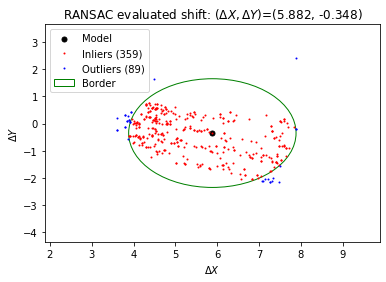

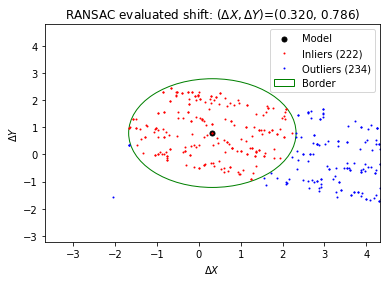

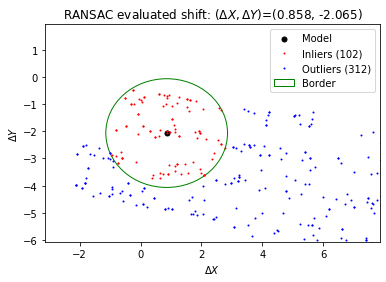

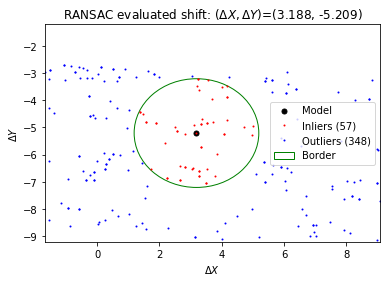

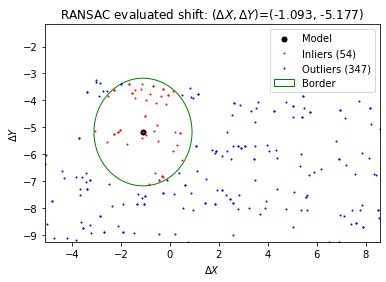

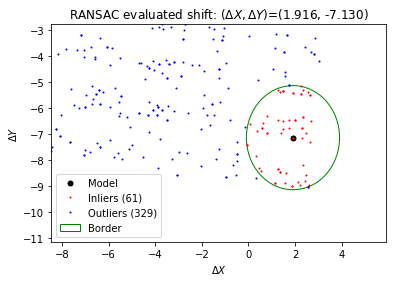

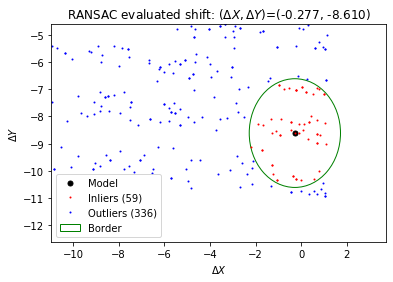

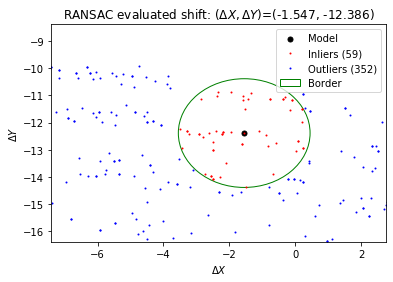

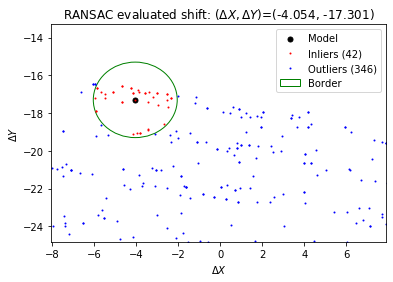

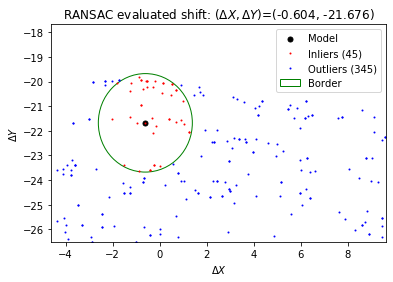

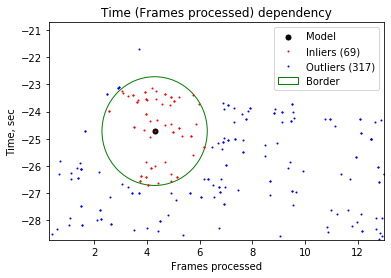

In [485]:
from timeit import default_timer as timer

src_frames_path = r"/Users/aleksandr/Programms/IAP2020/task4/src_frames"
img_files = [os.path.join(src_frames_path, f) for f in os.listdir(src_frames_path)]
imgs = [cv2.imread(f, cv2.IMREAD_COLOR) for f in sorted(img_files)]

results_dir = r"/Users/aleksandr/Programms/IAP2020/task4/results"
estimate_shifts(imgs, results_dir, dump_vis=True)


In [498]:
import imageio

def save_as_gif(src_dir, gif_path):
    images = []
    fnames = [os.path.join(src_dir, f) for f in os.listdir(src_dir)]
    for filename in fnames:
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_path, images,fps=6)

In [500]:
shifted_imgs_dir = os.path.join(results_dir, "shifted_images")
balanced_path = os.path.join(results_dir, 'balanced.gif')
save_as_gif(shifted_imgs_dir, balanced_path)

In [499]:
src_gif = os.path.join(results_dir, 'src.gif')
save_as_gif(src_frames_path, src_gif)

In [429]:
def shift_image(image, _delta_x, _delta_y):
    delta_x = int(round(_delta_x))
    delta_y = int(round(_delta_y))
    height, width = image.shape[0], image.shape[1]
    shifted = np.zeros_like(image, dtype=np.uint8)
    if delta_x >= 0 and delta_y >= 0:
        shifted[delta_y:height,delta_x:width] = image[0:height-delta_y,0:width-delta_x]
        shifted[0:delta_y,delta_x:width,:] = image[0:1,0:width-delta_x]
        shifted[delta_y:height,0:delta_x] = image[0:height-delta_y,0:1]
        shifted[0:delta_y,0:delta_x] = image[0,0]
    elif delta_x < 0 and delta_y > 0:
        shifted[delta_y:height,0:width+delta_x] = image[0:height-delta_y:,-delta_x:width]
        shifted[0:delta_y,0:width+delta_x] = image[0:1,-delta_x:width]
        shifted[delta_y:height,width+delta_x:width] = image[0:height-delta_y,-1:-2:-1]
        shifted[0:delta_y,width+delta_x:width] = image[0,-1]
    elif delta_x > 0 and delta_y < 0:
        shifted[0:height+delta_y,delta_x:width] = image[-delta_y:height,0:width-delta_x]
        shifted[0:height+delta_y,0:delta_x] = image[-delta_y:height, 0:1]
        shifted[height+delta_y:height,delta_x:width] = image[-1:-2:-1,0:width-delta_x]
        shifted[height+delta_y:height,0:delta_x] = image[-1,0]
    else:
        shifted[0:height+delta_y,0:width+delta_x] = image[-delta_y:height,-delta_x:width]
        shifted[height+delta_y:height,0:width+delta_x] = image[-1:-2:-1,-delta_x:width]
        shifted[0:height+delta_y, width+delta_x:width] = image[-delta_y:height,-1:-2:-1]
        shifted[height+delta_y:height,width+delta_x:width] = image[-1,-1]
    return shifted

In [437]:
shifted_dir = os.path.join(results_dir, "shifted_images")
if not os.path.exists(shifted_dir):
    os.makedirs(shifted_dir, exist_ok=False)
for i, (shift, img) in enumerate(zip(shifts, imgs[1:]), start=1):
    shifted_image = shift_img(img, -shift[0], -shift[1])
    cv2.imwrite(os.path.join(shifted_dir, f'shifted_{i}.png'), shifted_image)
cv2.imwrite(os.path.join(shifted_dir, f'shifted_0.png'), imgs[0])

True

In [411]:
a[:2,1:4] = np.array([50,51,51])
a

array([[ 0, 50, 51, 51],
       [ 4, 50, 51, 51],
       [ 8,  9, 10, 11]])

Found matches: 456
22 (1.4232330322265625, 0.9099807739257812)


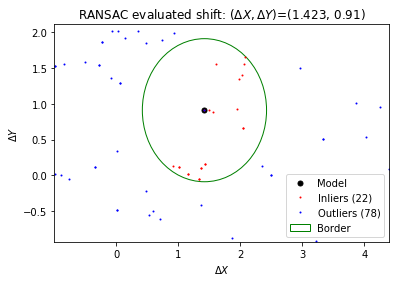

In [385]:
sift = cv2.SIFT_create()

kp0, des0 = sift.detectAndCompute(imgs[0], None)
kp1, des1 = sift.detectAndCompute(imgs[2], None)
_, matches = estimate_shift(kp0, des0, kp1, des1, r"/Users/aleksandr/Programms/IAP2020/task4/test_vis.png")

In [431]:
# for m in matches:
#     print(m)

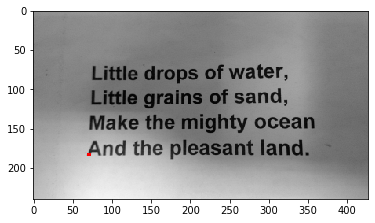

In [233]:
plt.imshow(marked_solopoint(frame0, kp0[matches[0][0]]))

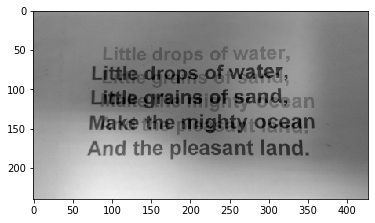

In [390]:
mixed_path = r"/Users/aleksandr/Programms/IAP2020/task4/mixed.png"
mixed = np.array(0.7 * imgs[0] + 0.3 * imgs[11], dtype=np.uint8)
cv2.imwrite(mixed_path, mixed)
plt.imshow(mixed)

True

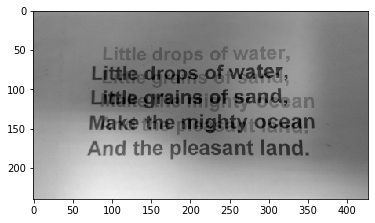

In [507]:
mixed = np.array(0.7 * imgs[0] + 0.3 * imgs[11], dtype=np.uint8)
plt.imshow(mixed)
cv2.imwrite(r"/Users/aleksandr/Programms/IAP2020/task4/mixed.png", mixed)

True

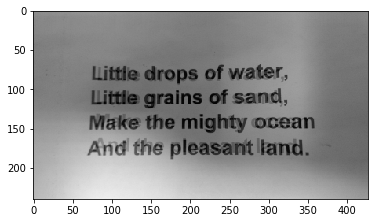

In [508]:
shifted11 = cv2.imread(r"/Users/aleksandr/Programms/IAP2020/task4/results/balanced_imgs/balanced_11.png", cv2.IMREAD_COLOR)
mixed2 = np.array(0.7 * imgs[0] + 0.3 * shifted11, dtype=np.uint8)
plt.imshow(mixed2)
cv2.imwrite(r"/Users/aleksandr/Programms/IAP2020/task4/mixed2.png", mixed2)

In [174]:
# def features(image):
#     keypoints = sift.detect(image, None)
#     keypoints, descriptors = sift.compute(image, keypoints)
#     return keypoints, descriptors

# def matcher(image1,image2,keypoints1,keypoints2,descriptors1,descriptors2,
#             matcher, descriptor):
#     if matcher == 'BF':
#         if (descriptor == 'SIFT') or (descriptor == 'SURF') or (descriptor == 'KAZE'):
#             normType = cv2.NORM_L2
#         else:
#             normType = cv2.NORM_HAMMING
#         BFMatcher = cv2.BFMatcher(normType = normType, crossCheck = True)
#         matches = BFMatcher.match(queryDescriptors = descriptors1, trainDescriptors = descriptors2)
#         matches = sorted(matches, key = lambda x: x.distance)
#         output = cv2.drawMatches(img1 = image1, keypoints1 = keypoints1,
#                                 img2 = image2,keypoints2 = keypoints2,
#                                 matches1to2 = matches[:30],
#                                 outImg = None,
#                                 flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#         return output, matches[:200]
#     elif matcher == 'FLANN':
#         FLANN_INDEX_KDTREE = 1
#         index_params = dict(algorithm = FLANN_INDEX_KDTREE,trees = 5)
#         search_params = dict(checks = 50)
#         descriptors1 = np.float32(descriptors1)
#         descriptors2 = np.float32(descriptors2)
#         FLANN = cv2.FlannBasedMatcher(indexParams = index_params, searchParams = search_params)
#         matches = FLANN.knnMatch(queryDescriptors = descriptors1,trainDescriptors = descriptors2,k = 2)
#         ratio_thresh = 0.7
#         good_matches = []
#         for m, n in matches:
#             if m.distance < ratio_thresh * n.distance:
#                 good_matches.append(m)
#         output = cv2.drawMatches(img1=image1,keypoints1 = keypoints1,
#                                 img2=image2,keypoints2 = keypoints2,
#                                 matches1to2 = good_matches,
#                                 outImg = None,
#                                 flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#         return output, good_matches
    
# frame0_gray = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
# frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

# kp0, des0 = features(frame0_gray)
# kp1, des1 = features(frame1_gray)
# ret, matches = matcher(frame0_gray, frame1_gray, kp0, kp1, des0, des1, 'BF', 'SIFT')
# print(len(matches))

200
